### Соловьёв Никита

Регрессия для синтетических данных

In [525]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [526]:
# Функуция для создания одномерных данных
def true_fun(x, a=np.pi, b = 0, f=np.sin):
    x = np.atleast_1d(x)[:]
    a = np.atleast_1d(a)
    
    if f is None: f = lambda x:x # line
    x = np.sum([ai*np.power(x, i+1) for i,ai in enumerate(a)],axis=0)

    return f(x+ b)

# Функция для добавления шумов 
def noises(shape , noise_power):
    return np.random.randn(*shape) *noise_power

# Объеденяем функционал для создания данных в одной функции
def dataset(a, b, f = None,  N = 250, x_max =1, noise_power = 0, random_x = True,  seed = 42):
    np.random.seed(seed)
    
    if random_x:
        x = np.sort(np.random.rand(N))*x_max    
    else:
        x = np.linspace(0,x_max,N)
    
    y_true = np.array([])
    
    for f_ in np.append([], f):
        y_true=np.append(y_true, true_fun(x, a, b, f_))
    
    y_true = y_true.reshape(-1,N).T
    y = y_true + noises(y_true.shape , noise_power)

    return y, y_true, np.atleast_2d(x).T

# Функция для визуализации данных
def vis_data(y, y_true, x, title):
    fig  = plt.figure(figsize=(15,10))
    plt.scatter(x[:,0], y, edgecolor='b', label='Зашумленные Данные', s=196, alpha = 0.6)
    plt.scatter(x[:,0], y_true, label='Реальные Данные', s=81,c='g', alpha = 0.8)
    plt.grid()
    plt.xlabel('x',fontsize=35)
    plt.ylabel('y',fontsize=35)
    plt.legend(fontsize=25)
    plt.title(title, fontsize=25)
    plt.xticks()
    plt.yticks()
    plt.tight_layout()

### 1.1 Линейная зависимость

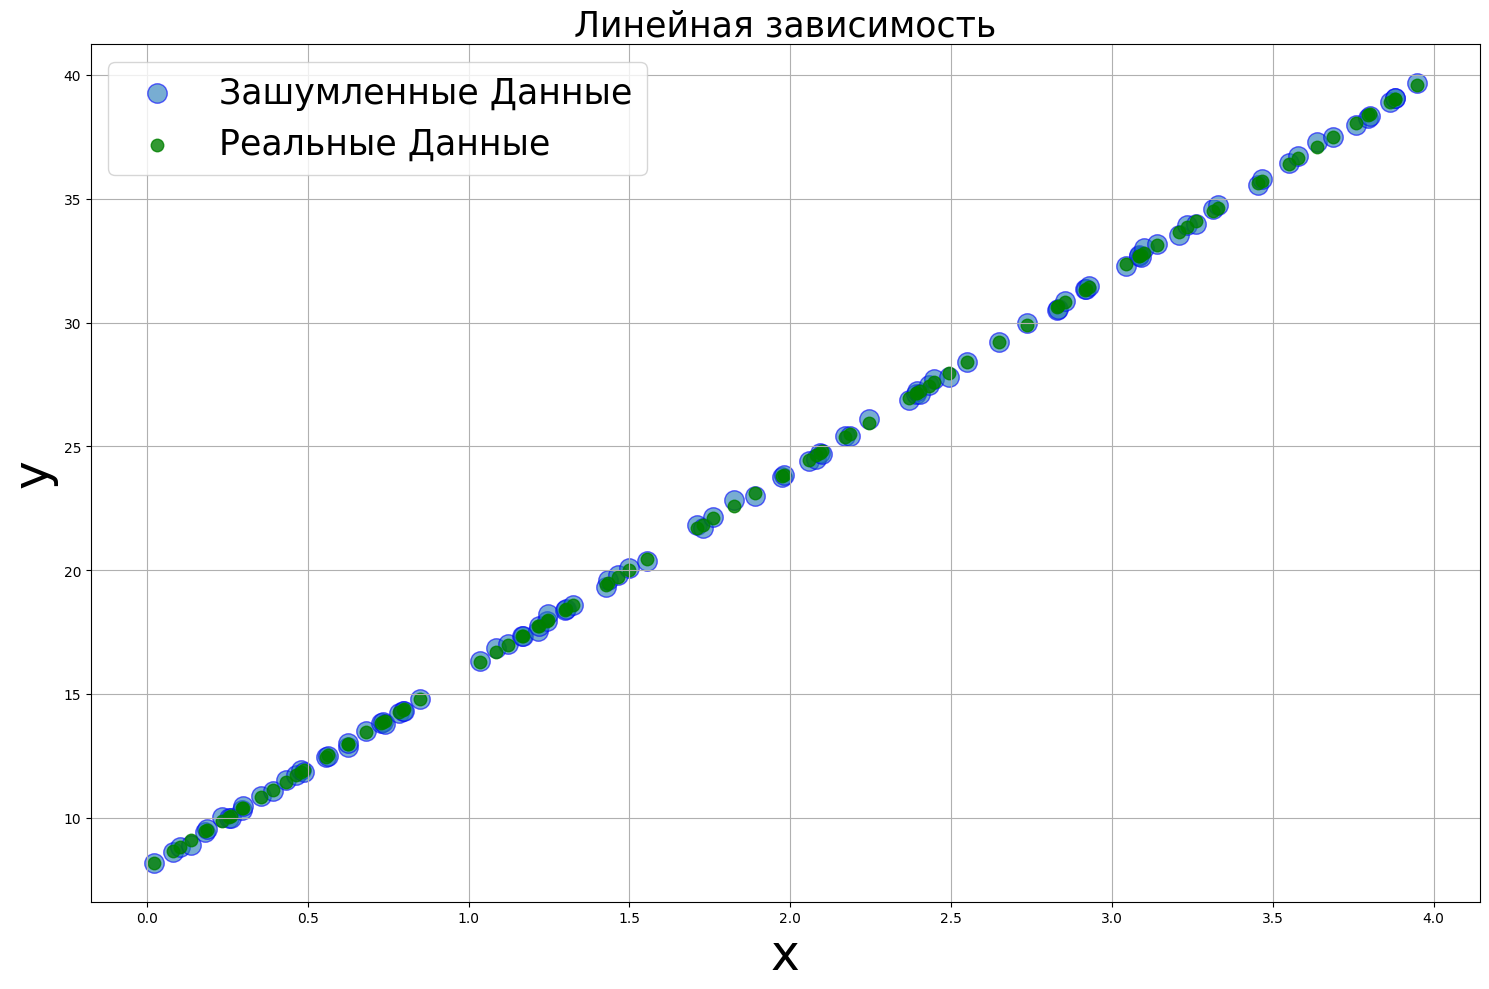

In [527]:
noise_power = 0.1 # шум

# зададаим данным линейную зависимость
y, y_true, x = dataset(a = 8, b = 8,
                       f = None,  N = 100,
                       x_max = 4, 
                       noise_power = noise_power,
                       seed = 42)
vis_data(y, y_true,x, 'Линейная зависимость')

### 1.2 Линейная регрессия

Объявим функции для создания и визуализации данных

In [528]:
# Функция для выделения тестовой и тренировочной выборки
def train_test_split(x,y, train_size=None, test_size=None, random_state=42, shuffle=True,):
    if random_state: np.random.seed(random_state)
    
    size = y.shape[0]
    idxs = np.arange(size)
    if shuffle: np.random.shuffle(idxs)
    
    if test_size and train_size is None:
        if (test_size<= 1):  train_size = 1 - test_size
        else:  train_size = size - test_size
        test_size = None    
        
    if train_size is None or train_size > size: train_size = size
        
    if (train_size<= 1): train_size *= size
        
    if test_size is not None: 
        if test_size<= 1: test_size *= size    
        if test_size>size: test_size = size-train_size
    else: test_size = 0

    x_train, y_train = x[idxs[:int(train_size)]], y[idxs[:int(train_size)]]
    x_val,   y_val   = x[idxs[int(train_size):size - int(test_size)]], y[idxs[int(train_size):size - int(test_size)]]
    
    if test_size > 0:
        x_test, y_test = x[idxs[size - int(test_size):]], y[idxs[size - int(test_size):]]
        return x_train, y_train.squeeze(), x_val, y_val.squeeze(), x_test, y_test.squeeze() 
    return x_train, y_train.squeeze(), x_val, y_val.squeeze()

Разделим данные на тренировочную и тестовую выборки

In [529]:
x_train, y_train,  x_test, y_test = train_test_split(x, y,  test_size=0.3)    
print(x_train.shape, y_train.shape,  x_test.shape, y_test.shape )

(70, 1) (70,) (30, 1) (30,)


Объявим функции для работы с регрессией

In [530]:
# Функция для инициализации весов
def init_weights(W_shape, add_bias = True, random_state = 42):
    W_shape = np.atleast_1d(W_shape)
    if random_state: 
        np.random.seed(random_state)
    W = np.random.randn(*list(W_shape))/np.sqrt(np.sum(W_shape))
    if add_bias: 
        W = np.column_stack((np.zeros(W.shape[-1]),W ))
    return W.squeeze()

# Функция для предсказания значений
def predict( X, W, add_bias = True):
    if add_bias:
        X_full = np.column_stack((np.ones(X.shape[0]),X))
    else:
        X_full = X
    return  np.dot(X_full, W)

# Функция для вычисления потерь
def loss_func(yhat, y):
    return np.square(yhat - y)

Протестируем функции

In [531]:
x_train[:1]

array([[3.23358939]])

Инициализируем веса и протестируем модель для первой строки данных

In [532]:
weights = init_weights(x.shape[1])
yhat = predict( x_train[0],weights)
loss = loss_func(yhat, y[0])

print(f'{weights}')
print(f'predict {yhat},\nground truth {y[0]},\nloss: {loss}')

[0.         0.49671415]
predict [1.60616962],
ground truth [8.18541245],
loss: [43.28643633]


Выведем график изменения функции потерь

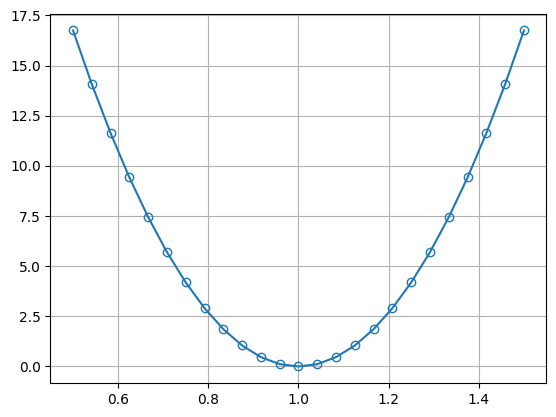

In [533]:
decline = np.linspace(start = 0.5, stop = 1.5,num = 25)
yhat = decline* y[0]
loss = loss_func(yhat, y[0])
plt.plot(decline,loss,'-o', mfc = 'none')
plt.grid()

Оптимизируем модель регрессии

In [534]:
# Функция оптимизации
def grad_loss(y_hat, y, X, add_bias = True):
    if add_bias:
        X_full = np.column_stack((np.ones(X.shape[0]),X))
    else:
        X_full = X
    return 2*np.dot(X_full.T, (y_hat - y)) / y.size

# Функция обновления весов
def update_weights(grad, W, learning_rate):
    return W - learning_rate*grad

# Функция обучения
def fit(X, y, learning_rate, weights = None,  epochs=30):
    if weights is None: weights = init_weights(X.shape[1])
    cost    = np.zeros(epochs)

    for i in range(epochs): 
        yhat    = predict(X,weights)
        grad    = grad_loss(yhat,  y, X)
        weights = update_weights(grad, weights, learning_rate)  
        cost[i] = loss_func(yhat,  y).mean()
                
    return weights, cost

In [535]:
# Проведем расчет градиента ошибки
yhat = predict(x_train[0], weights)

grad = grad_loss(yhat, y[0], x[0])
print(grad)

[-13.15848568  -0.2906508 ]


In [536]:
# Обновим весовые параметры
learning_rate = 0.1
weights = update_weights(grad, weights, learning_rate)
print(weights)

[1.31584857 0.52577923]


In [537]:
yhat = predict( x_train[0],weights)
loss = loss_func(yhat, y[0])

print(f'{weights}')
print(f'predict {yhat},\nground truth {y[0]},\nloss: {loss}')

[1.31584857 0.52577923]
predict [3.01600272],
ground truth [8.18541245],
loss: [26.72279704]


In [538]:
# Протестируем обучение
weights, cost = fit(x_train, y_train, learning_rate=0.1, epochs=40)

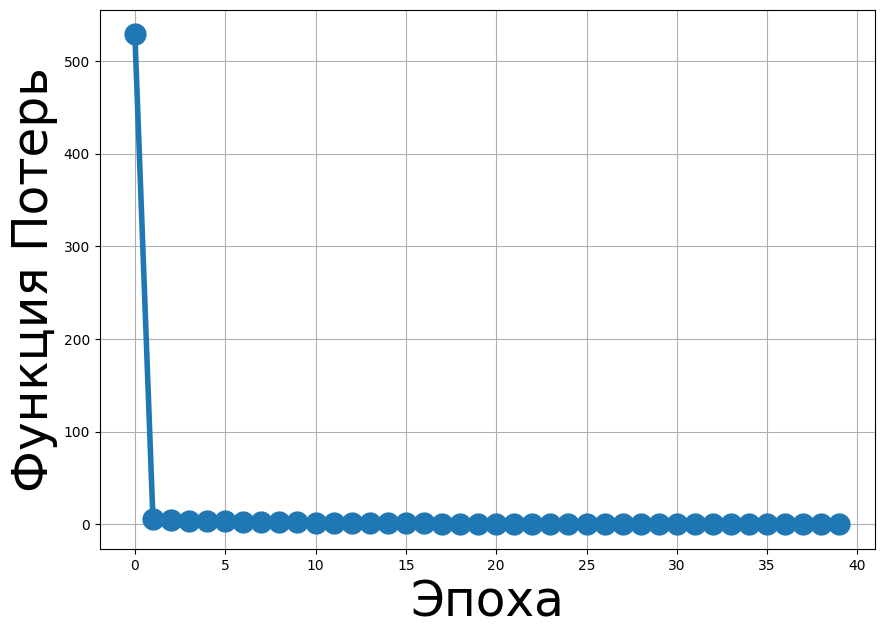

In [539]:
# Визуализируем изменение функции потерь
def plot_cost(cost):
    plt.plot(cost, 'o-', linewidth = 4, markersize = 15); 
    plt.grid()
    plt.xlabel('Эпоха',fontsize=35)
    plt.ylabel('Функция Потерь', fontsize=35)
    plt.xticks()
    plt.yticks()
    
fig  = plt.figure(figsize=(10,7))
plot_cost(cost)

Проверим точность функции

In [540]:
def r2_score(yhat, y):    
    return 1-(np.square(y-yhat)).sum(axis=0)/(np.square(y-np.mean(y, axis=0))).sum(axis=0)

predicts = predict( x_test,weights,)

r2_score(predicts, y_test), r2_score(predict(x_train,weights, ), y_train)

(0.9991233085532383, 0.999149828130137)

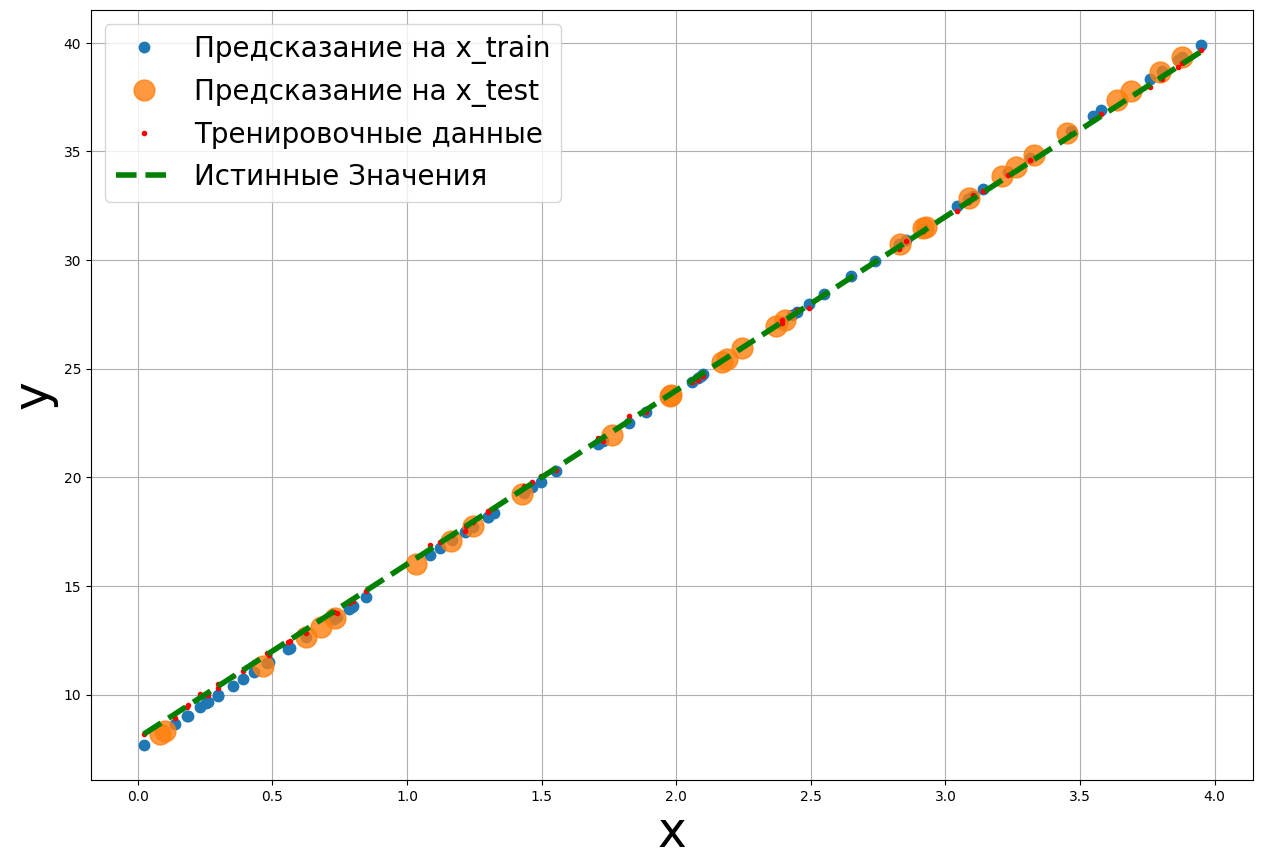

In [541]:
# Посмотрим на то, какая интерпретация может быть у предсказанных и заданных данных
def plot_model_weights(x_train, y_train, x_test, x, y, weights):
    plt.plot(x_train[:,0], predict(x_train,weights, ),
            '.', label='Предсказание на x_train',
            markersize = 15)
    plt.plot(x_test[:,0], predict(x_test,weights, ),
            'o', label='Предсказание на x_test',
            markersize = 15, alpha =0.8)
    plt.plot(x_train[:,0], y_train, '.',
            label='Тренировочные данные', linewidth=2,c='r')
    plt.plot(x[:,0], y, '--',
            label='Истинные Значения', linewidth=4,c='g')
    plt.legend(fontsize=20); plt.grid()
    plt.xlabel('x',fontsize=35)
    plt.ylabel('y',fontsize=35)
    plt.xticks()
    plt.yticks()

fig  = plt.figure(figsize=(15,10))

plot_model_weights(x_train, y_train, x_test, x, y_true, weights)

In [542]:
print(weights)

[7.50857299 8.2091735 ]


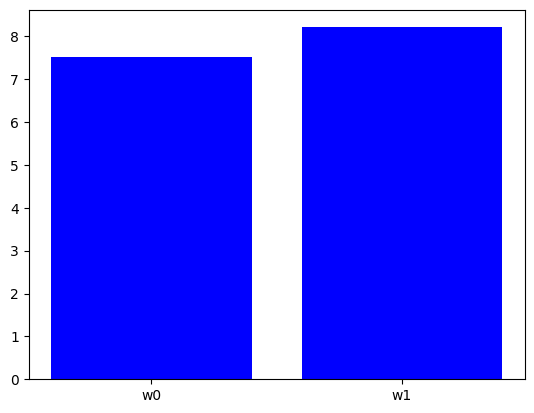

In [543]:
# Функиция визуализации весов
def vis_weigths(weights):
    numbers = np.arange(0,len(weights))
    tick_labels = ['w'+str(num) for num in numbers]
    cc=['']*len(numbers)
    for n,val in enumerate(weights):
        if val<0:
            cc[n]='red'
        elif val>=0:
            cc[n]='blue'

    plt.bar(x = numbers, height = weights, color = cc)
    plt.xticks(np.arange(0,len(weights)),tick_labels)

vis_weigths(weights)

In [544]:
BATCH = 10

# Функиция для генерации минибатчей заданного размера
def load_batch(X, y, batch_size = 100):
    idxs = np.arange(y.size)
    np.random.shuffle(idxs)
    for i_batch in range(0,y.size,batch_size):
        idx_batch = idxs[i_batch:i_batch+batch_size]
        x_batch   = np.take(X, idx_batch,axis=0)
        y_batch   = np.take(y, idx_batch)
        yield  x_batch, y_batch

# Функция оптимизации методом стохастического градиентного спуска
def fit_SGD(X, y, lerning_rate, weights = None,  epochs=30, batch_size = 100, random_state = 42):
    
    if random_state: np.random.seed(random_state)

    if weights is None: weights = init_weights(X.shape[1])
    if batch_size is None or batch_size>y.size : batch_size = y.size
    n_batches = y.size//batch_size
    
    cost    = np.zeros(epochs)

    for i in range(epochs): 
        loss = 0
        for cnt,(x_batch, y_batch) in enumerate(load_batch(X,y, batch_size)): 

            yhat    = predict(x_batch, weights)
            grad    = grad_loss(yhat,  y_batch, x_batch) 
            weights = update_weights(grad, weights, lerning_rate) #backward 
            loss   += loss_func(yhat,  y_batch).mean()

            if cnt>= n_batches:
                break
        cost[i] = loss/n_batches

    return weights, cost

In [545]:
weights = init_weights(x_train.shape[1], random_state=42)

weights, cost = fit_SGD(x_train, y_train, lerning_rate=0.1, batch_size = 10,  epochs=10)

predicts = predict(x_test, weights, )
r2_score(predicts, y_test), r2_score(predict(x_train,weights, ), y_train)

print(weights)

[7.87866699 8.02995949]


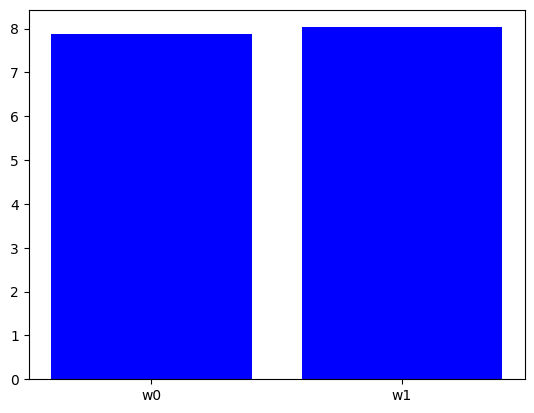

In [546]:
vis_weigths(weights)

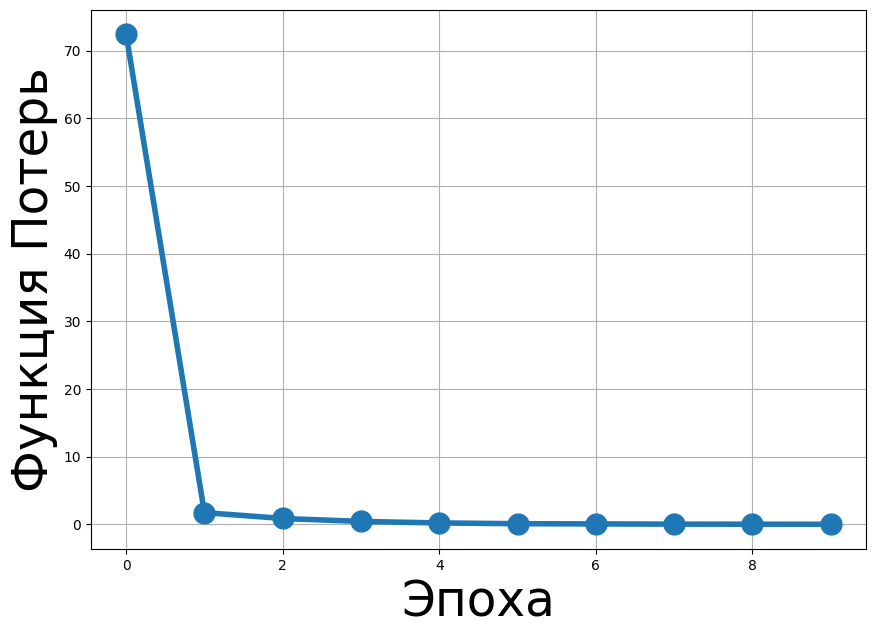

In [547]:
fig  = plt.figure(figsize=(10,7))

plot_cost(cost)

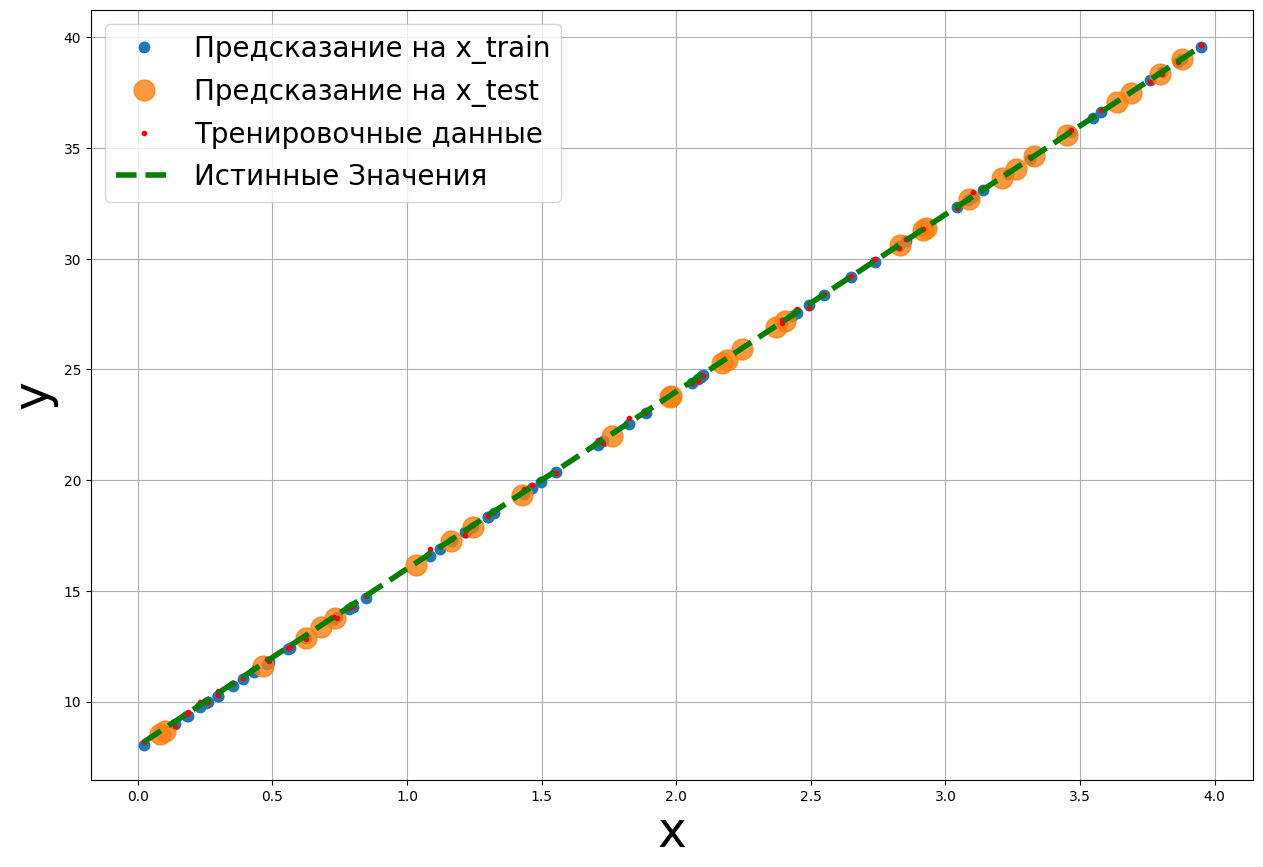

In [548]:
fig  = plt.figure(figsize=(15,10))

plot_model_weights(x_train, y_train, x_test, x, y_true, weights)

Объеденим все функции в один класс для работы с регрессией

In [549]:
class LinearRegression():
    def __init__(self, 
                 learning_rate = 0.5, 
                 epochs = 100, 
                 weights = None, 
                 bias    = None, 
                 batch_size   = 1000,
                 n_batches    = None,
                 random_state = 42):
        self.lr      = learning_rate
        self.epochs  = epochs
        self.weights = weights
        self.bias    = bias
        self.seed    = random_state
        self.batch_size = batch_size
        self.cost    = np.zeros(epochs)
        
        self.n_batches = n_batches
        
        if not(self.weights is None) and (self.bias):
            if self.weights.size == X.shape[1]:
                self.weights = np.append(self.bias,self.weights)
    
    #---------------------------------
    def forward(self, X):
        return np.dot(X, self.weights)
    
    #---------------------------------
    def loss(self,yhat, y):
        return np.square(yhat - y).sum()/y.size
    
    #---------------------------------
    def grad_step(self,yhat, y, X):
        return 2*np.dot(X.T, (yhat - y)) / y.size
    
    #---------------------------------
    def update(self):    
        return self.weights - self.lr*self.grad
    
    #---------------------------------
    def init(self, weights_size):
        np.random.seed(self.seed)
        return np.random.randn(weights_size)/np.sqrt(weights_size)
    
    #---------------------------------
    def predict(self, X):
        yhat = self.forward(self.add_bias(X))
        return yhat.squeeze()
    
    #---------------------------------
    def score(self, X, y):        
        yhat = self.predict(X)
        return 1-np.sum(np.square(y-yhat))/np.sum(np.square(y-np.mean(y)))
    
    #---------------------------------
    def fit(self, X, y):

        np.random.seed(self.seed)

        if self.weights is None:
            self.weights = self.init(X.shape[1])
        
        if self.bias is None: 
            self.bias    = self.init(1)
        
        if self.weights.size == X.shape[1]:
            self.weights = np.append(self.bias,self.weights)
        
        self.grad    = np.zeros(self.weights.shape)
        self.cost    = np.zeros(self.epochs)

        if self.batch_size is None:            
            self.batch_size = y.size
            
        if self.n_batches is None:
            self.n_batches = y.size//self.batch_size
            
        for i in range(self.epochs): 
            loss = 0
            for cnt,(x_batch, y_batch) in enumerate(self.load_batch(X,y)): 

                yhat         = self.forward(x_batch)
                self.grad    = self.grad_step(yhat,  y_batch, x_batch) 
                self.weights = self.update() 
                loss += self.loss(yhat,  y_batch)
                
                if cnt>= self.n_batches:
                    break
            self.cost[i] = loss/self.n_batches
        
        self.bias = self.weights[0]
    #---------------------------------
    def load_batch(self,X,y):
        idxs = np.arange(y.size)
        np.random.shuffle(idxs)

        for i_batch in range(0,y.size,self.batch_size):
            idx_batch = idxs[i_batch:i_batch+self.batch_size]
            x_batch   = np.take(X, idx_batch,axis=0)
            x_batch   = self.add_bias(x_batch)
            y_batch   = np.take(y, idx_batch)
            yield  x_batch, y_batch
    
    #---------------------------------
    def add_bias(self, X):
        return np.column_stack((np.ones(X.shape[0]), X))
    
    #---------------------------------
    def plot_cost(self, figsize = (12,6), title = ''):
        plt.figure(figsize = figsize)
        plt.plot(self.cost)
        plt.grid()
        plt.xlabel('Эпоха', fontsize = 24)
        plt.ylabel('Функция Потерь', fontsize = 24)
        plt.title(title, fontsize = 24)
        plt.show()
    
    #---------------------------------
    def get_w_and_b(self):
        return (self.weights[1:], self.bias)

### 2.1 Полиномиальная Зависимость

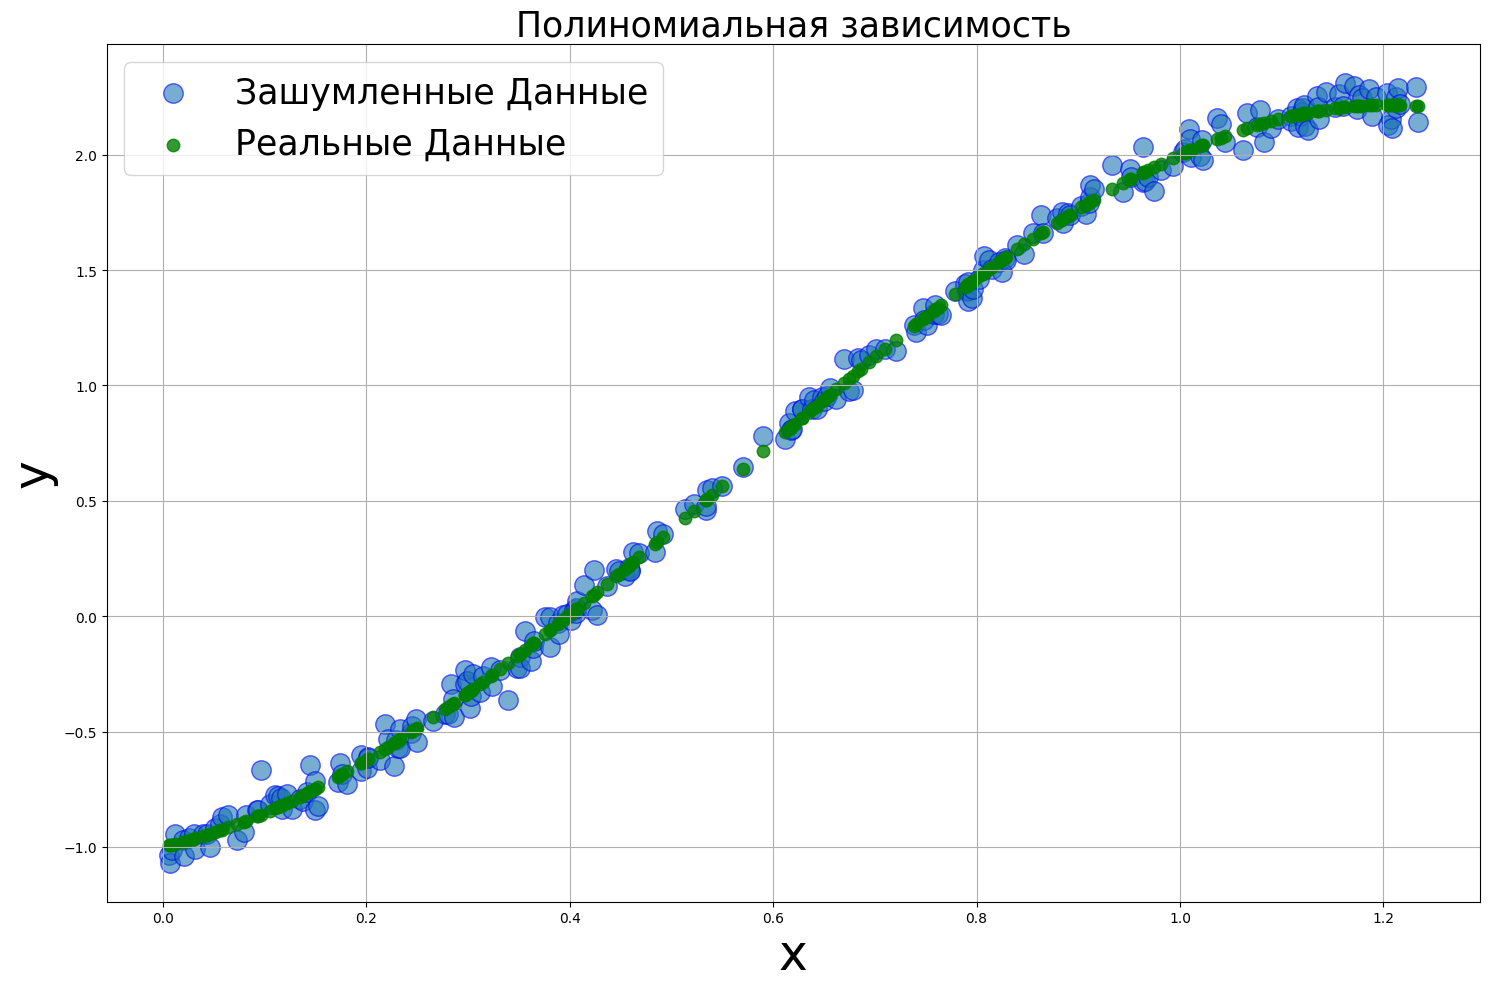

In [550]:
noise_power = 0.05

y, y_true, x = dataset(a = [1, 5, -3], b = -1,
                       f = None,  N = 250,
                       x_max = 1.25, 
                       noise_power = noise_power,
                       seed = 42)
vis_data(y, y_true,x, 'Полиномиальная зависимость')

In [551]:
x_train, y_train,  x_test, y_test = train_test_split(x, y,  test_size=0.3)

regr_poly_lin = LinearRegression(learning_rate=0.1,
                                epochs=10,batch_size=10,
                                n_batches=None)

regr_poly_lin.fit(x_train, y_train)

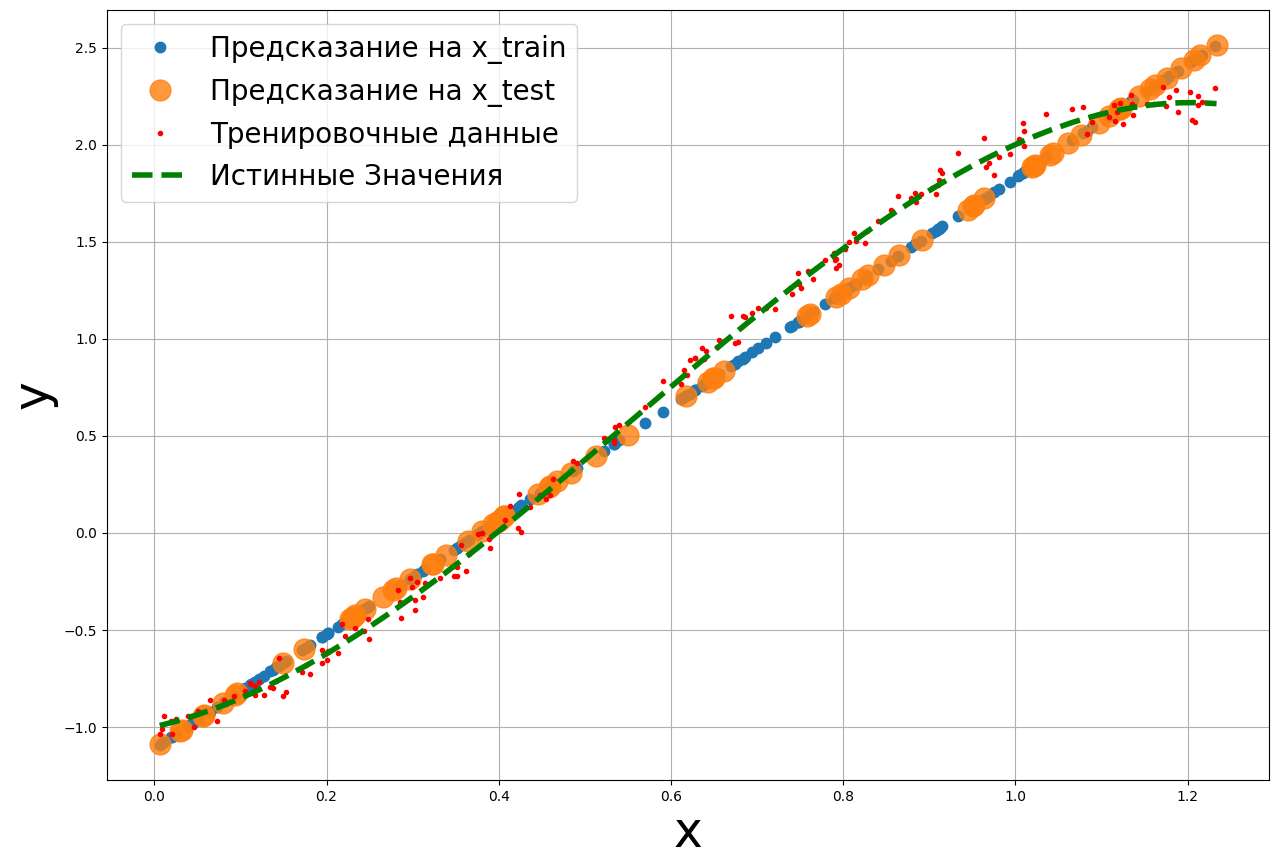

In [552]:
def plot_model_class(x_train, y_train, x_test, x, y, model):
    plt.plot(x_train[:,0], model.predict(x_train),
            '.', label='Предсказание на x_train',
            markersize = 15)
    plt.plot(x_test[:,0], model.predict(x_test),
            'o', label='Предсказание на x_test',
            markersize = 15, alpha =0.8)
    plt.plot(x_train[:,0], y_train, '.',
            label='Тренировочные данные', linewidth=2,c='r')
    plt.plot(x[:,0], y, '--',
            label='Истинные Значения', linewidth=4,c='g')
    plt.legend(fontsize=20); plt.grid()
    plt.xlabel('x',fontsize=35)
    plt.ylabel('y',fontsize=35)
    plt.xticks()
    plt.yticks()

fig  = plt.figure(figsize=(15,10))

plot_model_class(x_train, y_train, x_test, x, y_true, regr_poly_lin)

### 2.2 Полиномиальная регрессия

In [553]:
def to_polynom(x, order = 1, add_bias = False):
    order_range = range( 0 if add_bias else 1, order+1, 1)
    x = np.atleast_1d(x)[:]    
    out = np.array([])
    for i in order_range:
        out = np.append(out, np.power(x,i))
    return out.reshape(-1, x.size).T

In [554]:
x_ = to_polynom(x, order = 3) 
x_train, y_train,  x_test, y_test = train_test_split(x_, y,  test_size=0.3)

regr_poly = LinearRegression(learning_rate=0.1,
                            epochs=100,batch_size=10,
                            n_batches=None)

regr_poly.fit(x_train, y_train)

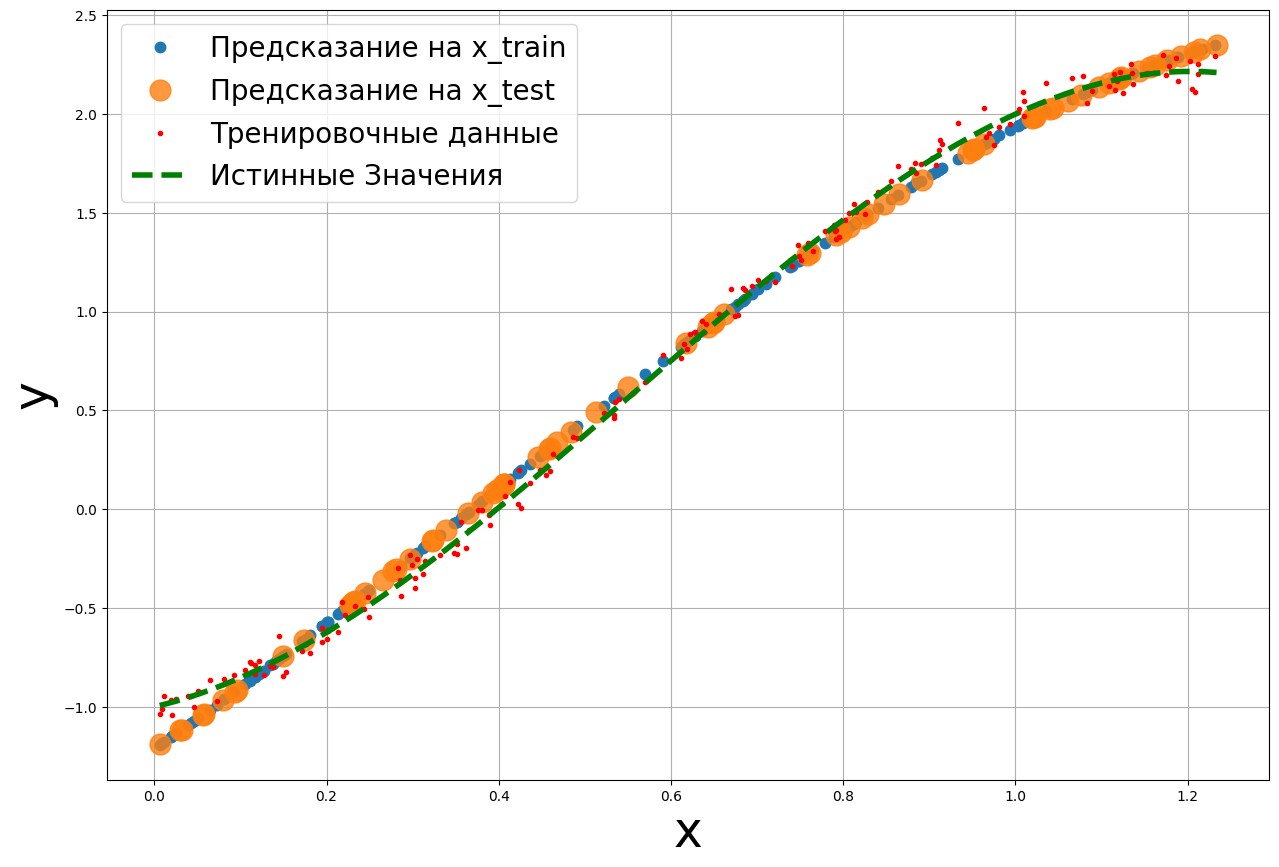

In [555]:
fig  = plt.figure(figsize=(15,10))

plot_model_class(x_train, y_train, x_test, x, y_true, regr_poly)

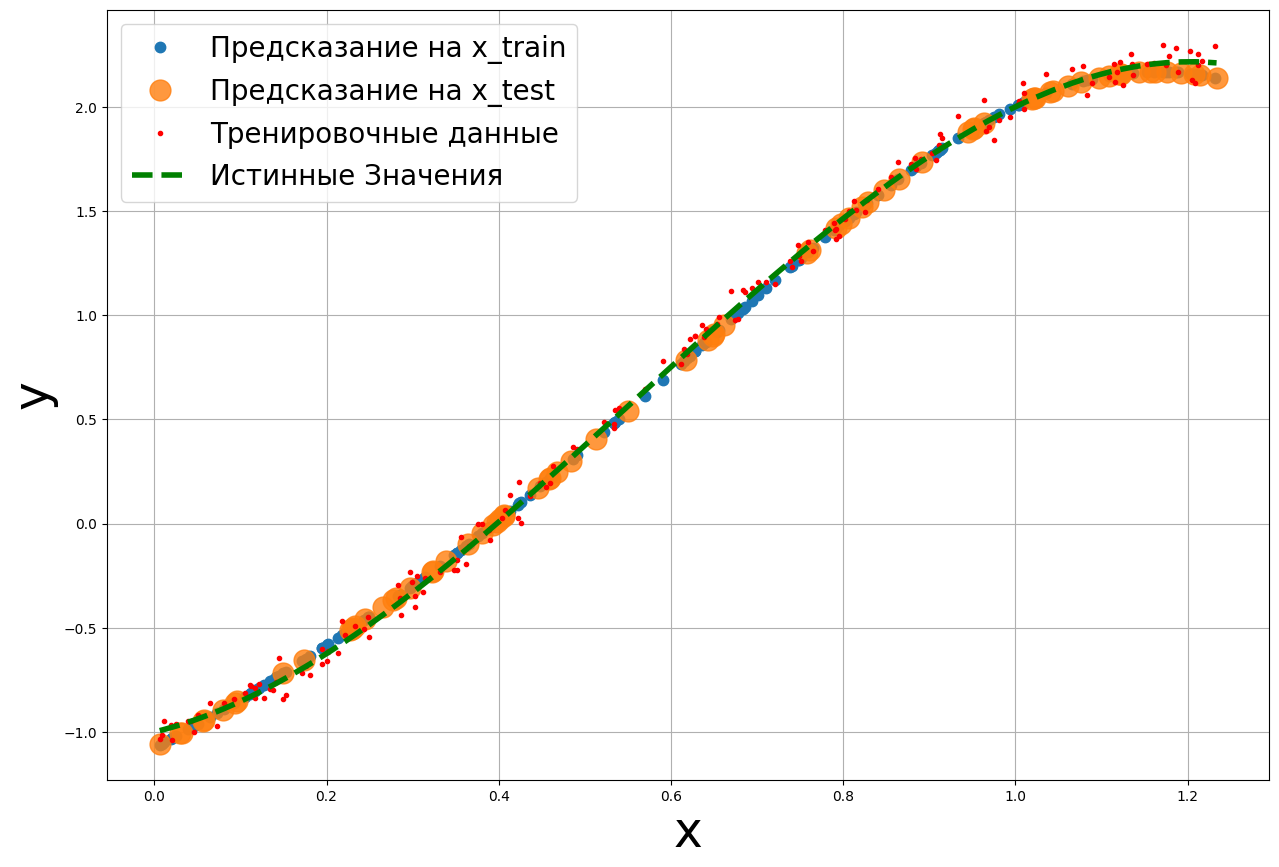

In [556]:
x_ = to_polynom(x, order = 8) 
x_train, y_train,  x_test, y_test = train_test_split(x_, y,  test_size=0.3, )

regr_poly = LinearRegression(learning_rate=0.1,
                            epochs=100, batch_size=10,
                            n_batches=None)

regr_poly.fit(x_train, y_train)

fig  = plt.figure(figsize=(15,10))

plot_model_class(x_train, y_train, x_test, x, y_true, regr_poly)

### 3.1 Гармоническая зависимость

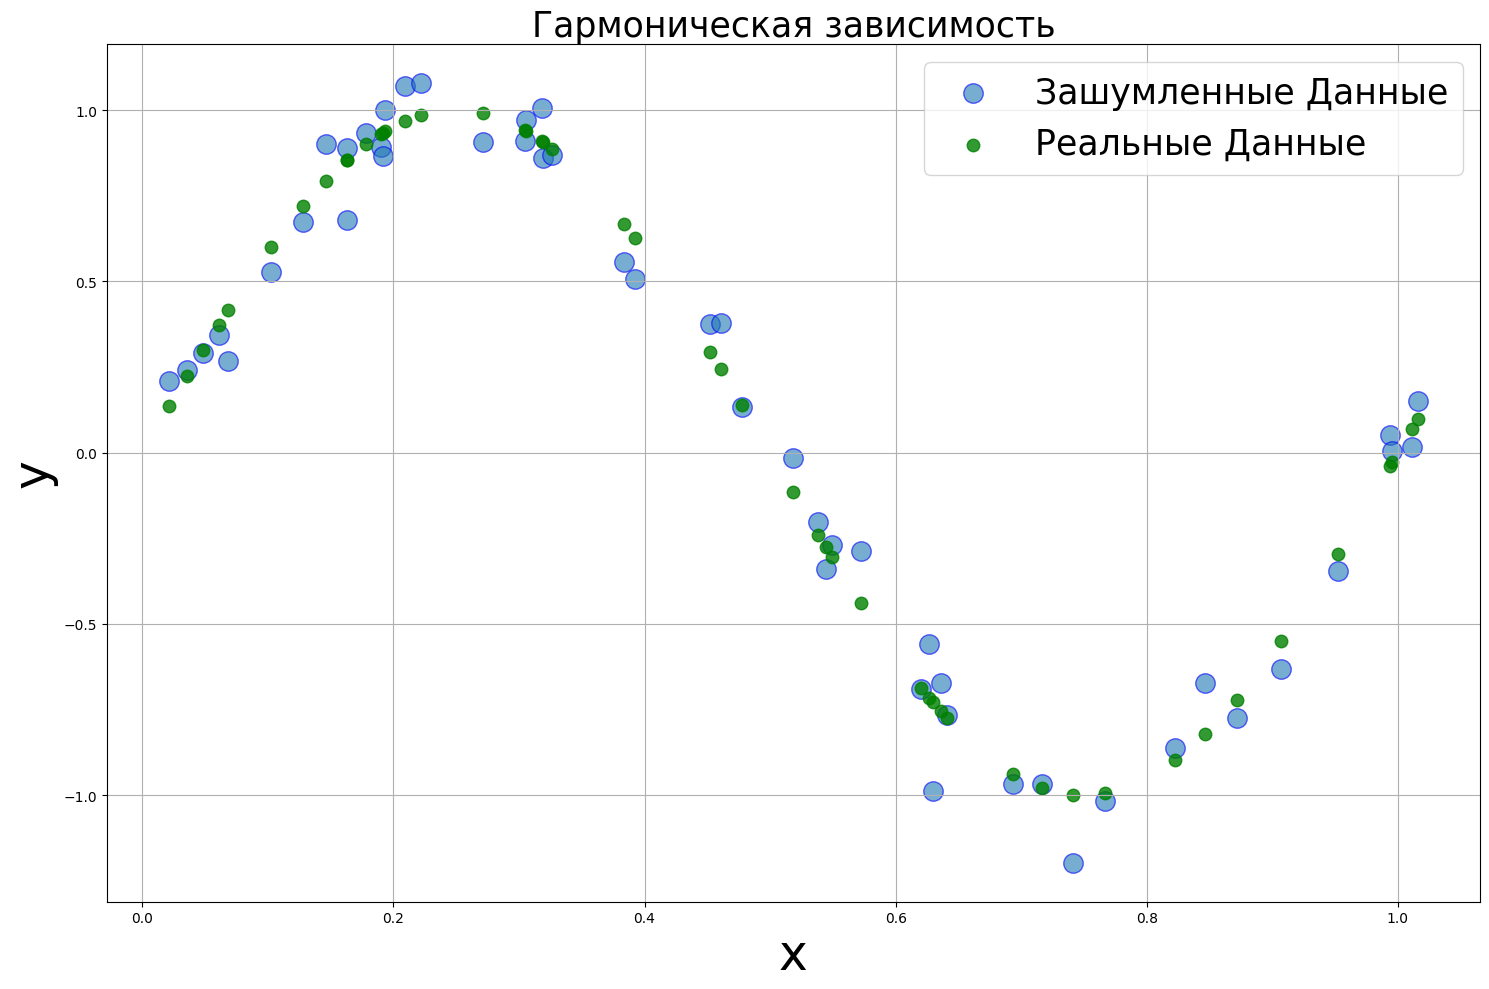

In [557]:
y, y_true, x = dataset(a = 2 * np.pi,
                       b = np.pi * 1.5, f = np.cos,  
                       N = 50, x_max = np.pi / 3, 
                       noise_power = 0.1, seed = 42)
vis_data(y, y_true, x, 'Гармоническая зависимость')

In [558]:
x_train, y_train,  x_test, y_test = train_test_split(x, y,  test_size=0.3, )    
print(x_train.shape, y_train.shape,  x_test.shape, y_test.shape )

(35, 1) (35,) (15, 1) (15,)


Train Score = 0.43


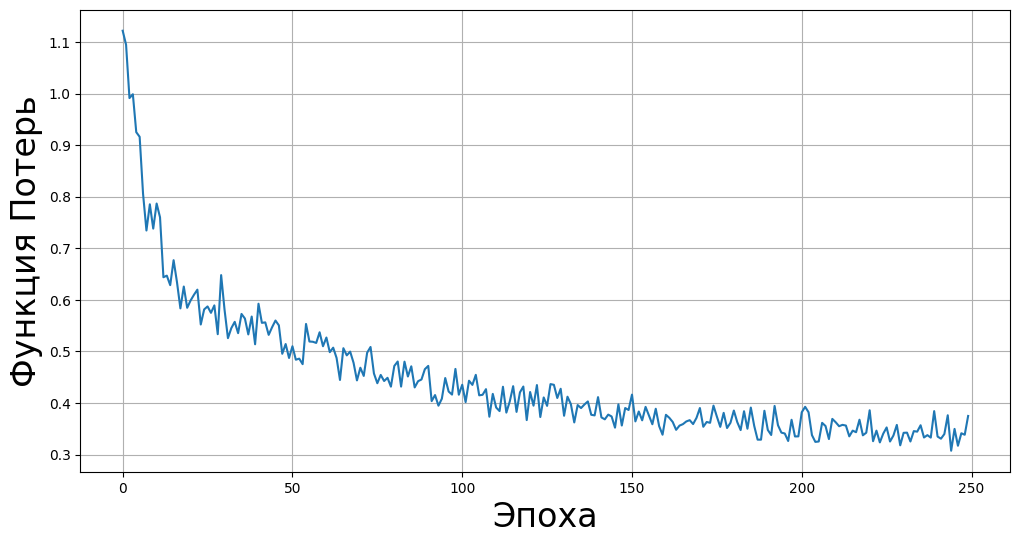

In [559]:
regr_harm = LinearRegression(learning_rate=0.01,
                            epochs=250, batch_size=10,
                            n_batches=None)
regr_harm.fit(x_train, y_train)

print(f'Train Score = {regr_harm.score(x_train, y_train):.2f}')
regr_harm.plot_cost()

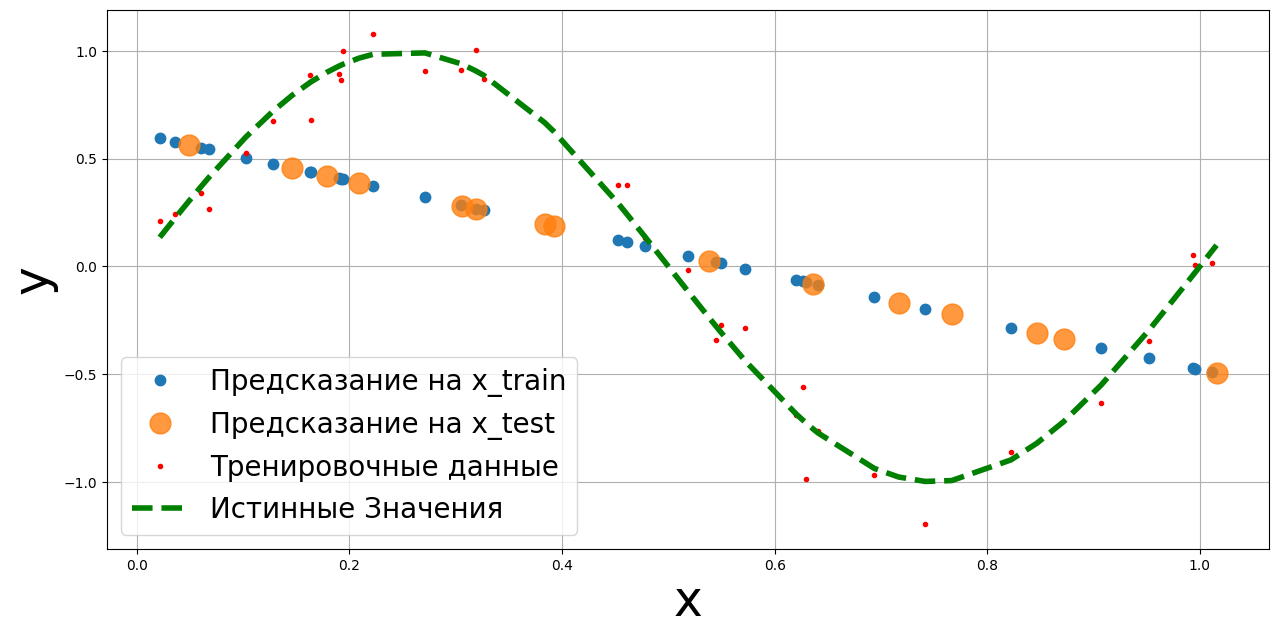

In [560]:
fig  = plt.figure(figsize=(15,7))

plot_model_class(x_train, y_train, x_test, x, y_true, regr_harm)

[-1.09717759] 0.6177493540069897


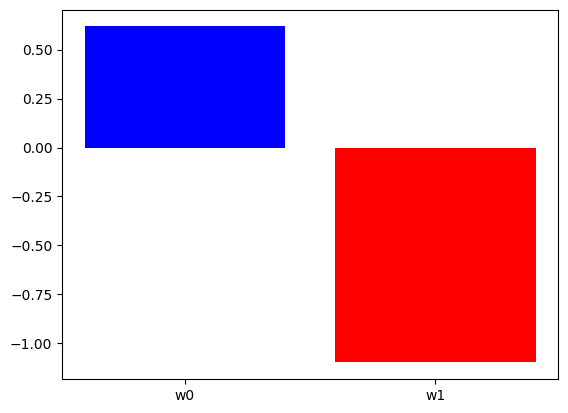

In [561]:
w, b = regr_harm.get_w_and_b()
print(w,b)
vis_weigths(np.hstack([b,w]))

### 3.2 Полиномиальная регрессия

Создадим набор данных

In [562]:
order  = 10

x_train_ = to_polynom(x_train, order=order)
x_test_  = to_polynom(x_test,  order=order)

pd.DataFrame(x_train_).tail(4)

,0,1,2,3,4,5,6,7,8,9
31,0.190407,0.036255,0.006903,0.001314,2.502711e-04,4.765328e-05,9.073502e-06,1.727655e-06,3.289571e-07,6.263562e-08
32,0.640731,0.410536,0.263043,0.168540,1.079887e-01,6.919167e-02,4.433324e-02,2.840567e-02,1.820039e-02,1.166155e-02
33,0.036012,0.001297,0.000047,0.000002,6.056345e-08,2.180985e-09,7.854071e-11,2.828375e-12,1.018542e-13,3.667931e-15
34,0.326423,0.106552,0.034781,0.011353,3.705990e-03,1.209721e-03,3.948808e-04,1.288982e-04,4.207534e-05,1.373436e-05


Test Score = 0.67, Train Score = 0.61


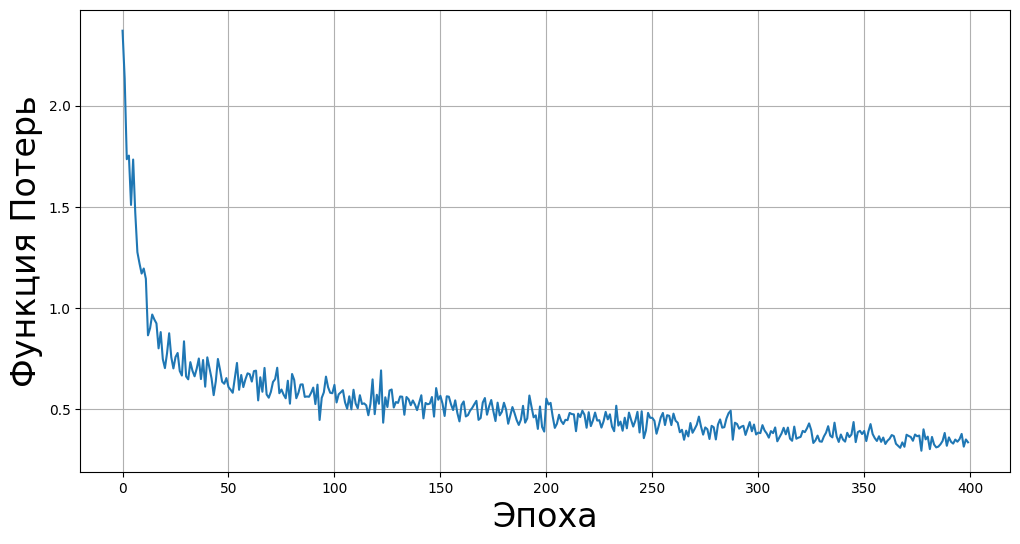

In [563]:
regr_harm_poly = LinearRegression(learning_rate=0.01,
                                  epochs=400, batch_size=25,
                                  n_batches=None)

regr_harm_poly.fit(x_train_, y_train)
print(f'Test Score = {regr_harm_poly.score(x_test_, y_test):.2f}, Train Score = {regr_harm_poly.score(x_train_, y_train):.2f}')
regr_harm_poly.plot_cost()

[-0.72830374 -0.85476799 -0.35012305  0.15261179 -0.23398984 -0.11231796
  0.54832194  0.3546848   0.00981224  0.36436953] 0.6341900934778134


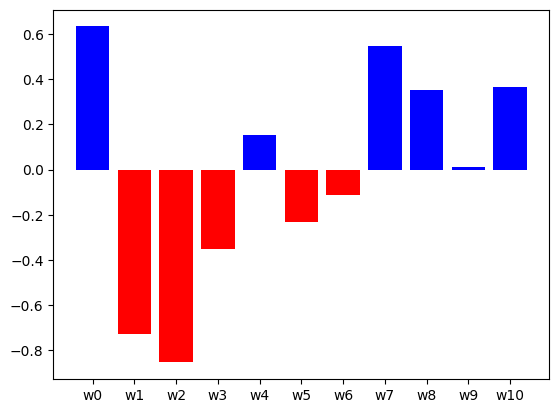

In [565]:
w, b = regr_harm_poly.get_w_and_b()
print(w,b)
vis_weigths(np.hstack([b,w]))

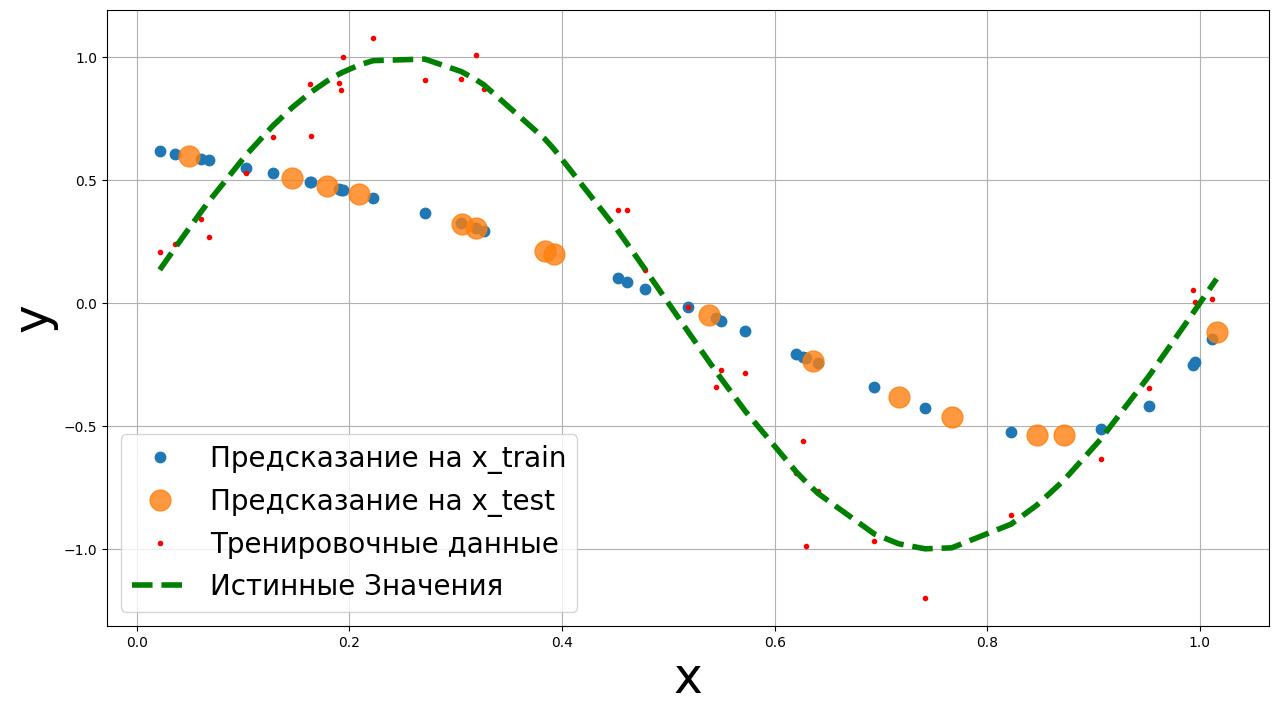

In [566]:
np.sum(np.abs(w))

plt.figure(figsize=(15,8))

plot_model_class(x_train_, y_train, x_test_, x, y_true, regr_harm_poly)

In [567]:
class MinMaxScaler:
    def __init__(self):
        self.min = 0
        self.max = 0
    def fit(self,X):
        self.min = X.min(axis = 0)
        self.max = X.max(axis = 0)
        return self
    def transform(self,X):
        return (X- self.min)/(self.max-self.min)
    def fit_transform(self,X):
        return self.fit(X).transform(X)


class StandardScaler:
    def __init__(self):
        self.mean = 0
        self.std = 1
    def fit(self,X):
        self.mean = X.mean(axis = 0)
        self.std = X.std(axis = 0)
        return self
    def transform(self,X):
        return (X- self.mean)/(self.std)
    def fit_transform(self,X):
        return self.fit(X).transform(X)

In [568]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_)
x_test_scaled = scaler.transform(x_test_)

In [569]:
pd.DataFrame(x_test_scaled).tail(4)

,0,1,2,3,4,5,6,7,8,9
11,1.290826,1.314799,1.202790,1.042037,0.873383,0.713301,0.567758,0.438375,0.324924,0.226372
12,-0.818138,-0.806942,-0.701026,-0.607631,-0.541376,-0.496097,-0.464670,-0.442123,-0.425319,-0.412306
13,0.271678,-0.030467,-0.232614,-0.342675,-0.395187,-0.416225,-0.421213,-0.418529,-0.412527,-0.405378
14,0.860650,0.673987,0.441925,0.236037,0.072468,-0.051594,-0.143407,-0.210200,-0.258052,-0.291783


Test Score = 0.84, Train Score = 0.83


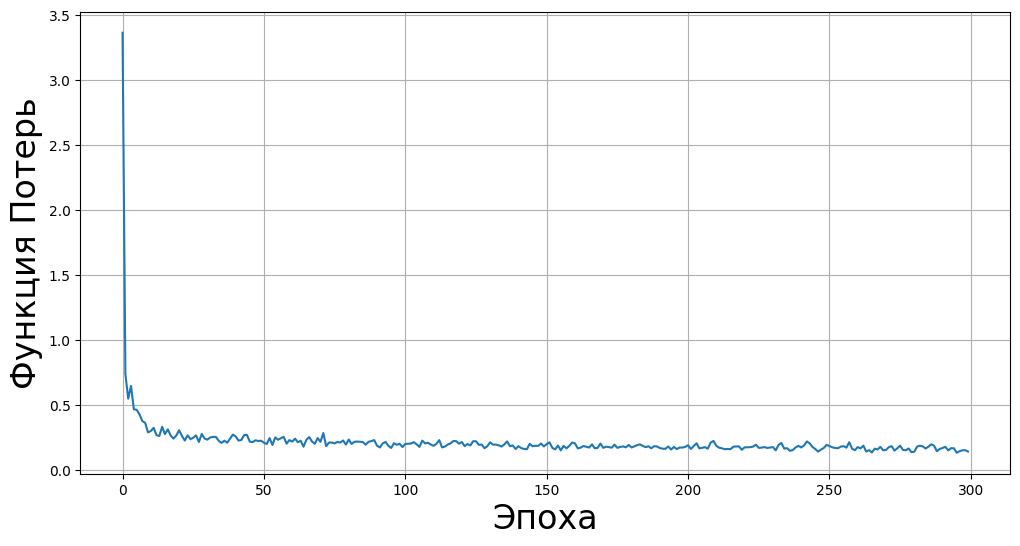

In [570]:
regr_harm_poly_scale = LinearRegression(learning_rate=0.05,
                                        epochs=300, batch_size=25,
                                        n_batches=None)

regr_harm_poly_scale.fit(x_train_scaled, y_train)
print(f'Test Score = {regr_harm_poly_scale.score(x_test_scaled, y_test):.2f}, Train Score = {regr_harm_poly_scale.score(x_train_scaled, y_train):.2f}')
regr_harm_poly_scale.plot_cost()

[ 0.32760477 -1.07168372 -0.64516181  0.03753684 -0.19773875 -0.00380078
  0.6606211   0.42247256  0.00213372  0.26291231] 0.10880029092889201


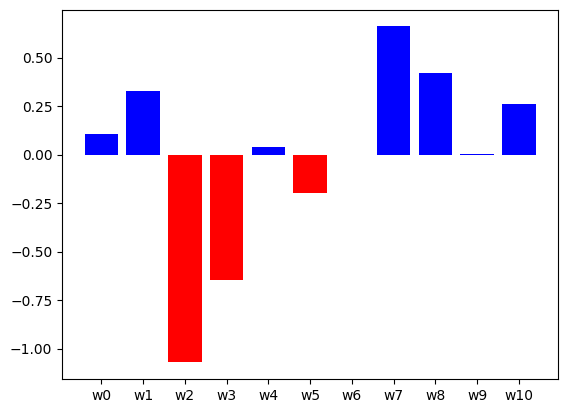

In [572]:
w, b = regr_harm_poly_scale.get_w_and_b()
print(w, b)
vis_weigths(np.hstack([b,w]))

(array([-1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5,  2. ,  2.5]),
 [Text(0, -1.5, '−1.5'),
  Text(0, -1.0, '−1.0'),
  Text(0, -0.5, '−0.5'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.5, '0.5'),
  Text(0, 1.0, '1.0'),
  Text(0, 1.5, '1.5'),
  Text(0, 2.0, '2.0'),
  Text(0, 2.5, '2.5')])

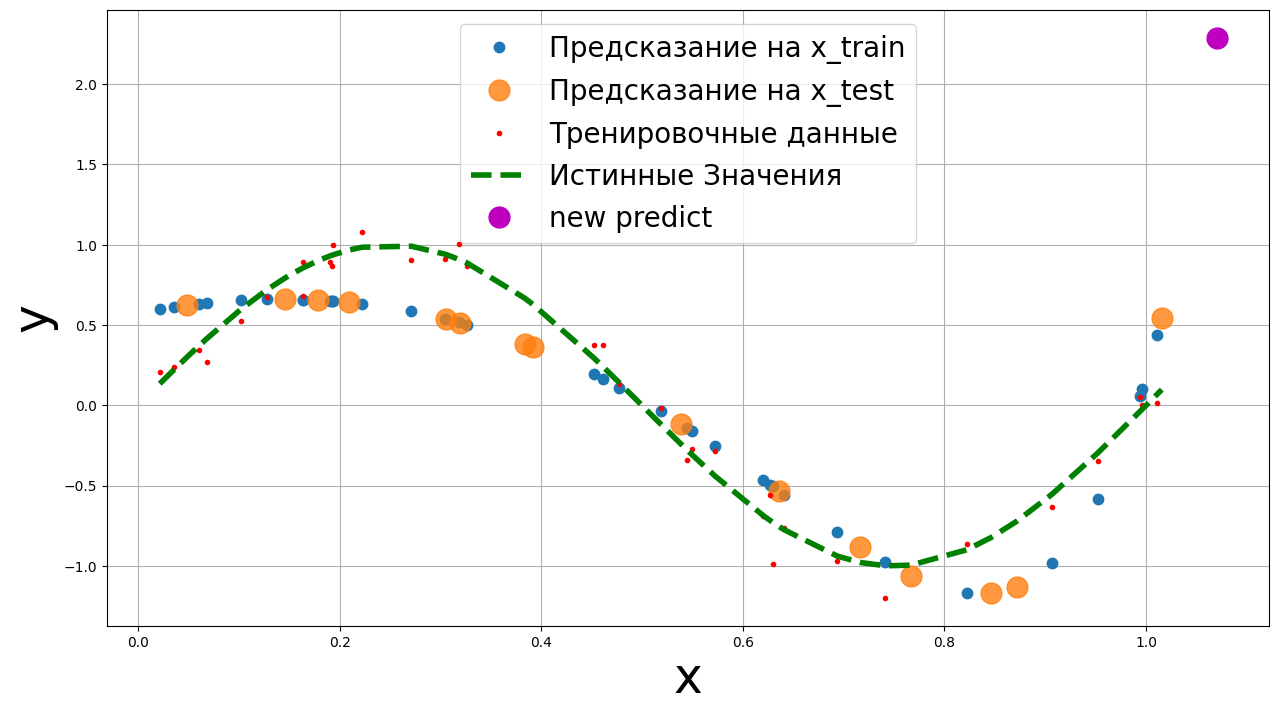

In [573]:
np.sum(np.abs(w))

plt.figure(figsize=(15,8))

plt.plot(x_train_[:,0], regr_harm_poly_scale.predict(x_train_scaled),
        '.', label='Предсказание на x_train',
        markersize = 15)
plt.plot(x_test[:,0], regr_harm_poly_scale.predict(x_test_scaled),
        'o', label='Предсказание на x_test',
        markersize = 15, alpha =0.8)
plt.plot(x_train_[:,0], y_train, '.',
        label='Тренировочные данные', linewidth=2,c='r')
plt.plot(x[:,0], y_true, '--',
        label='Истинные Значения', linewidth=4,c='g')

plt.plot([1.07], 
         regr_harm_poly_scale.predict(scaler.transform(to_polynom([1.07], order=order))), 
         'mo',  label = 'new predict',
        markersize = 15 )
plt.legend(fontsize=20); plt.grid()
plt.xlabel('x', fontsize=35)
plt.ylabel('y', fontsize=35)
plt.xticks()
plt.yticks()

### 4. Регуляризация линейной регрессии

Регуляризация Тихонова

In [574]:
class RidgeRegression(LinearRegression):
    def __init__(self, 
                 learning_rate = 0.5,
                 l2_penalty = 0.001,
                 epochs = 100, 
                 weights = None, 
                 bias    = None, 
                 batch_size   = 1000, 
                 n_batches    = None,
                 random_state = 42):
        
        super().__init__(learning_rate = learning_rate,
                         epochs = epochs, 
                         weights = weights, 
                         bias    = bias, 
                         batch_size   = batch_size, 
                         n_batches    = n_batches,
                         random_state = random_state)
        self.l2_penalty = l2_penalty
        
    #---------------------------------
    def loss(self,yhat, y):   
        l2_term = (self.l2_penalty/2)*np.sum(np.square(self.weights[1:]))
        return np.square(yhat - y).mean() + l2_term

    #---------------------------------
    def update(self):    
        l2_term = self.l2_penalty*np.mean(self.weights[1:])
        return self.weights - self.lr*(self.grad + l2_term)  

Test Score = 0.81, Train Score = 0.81


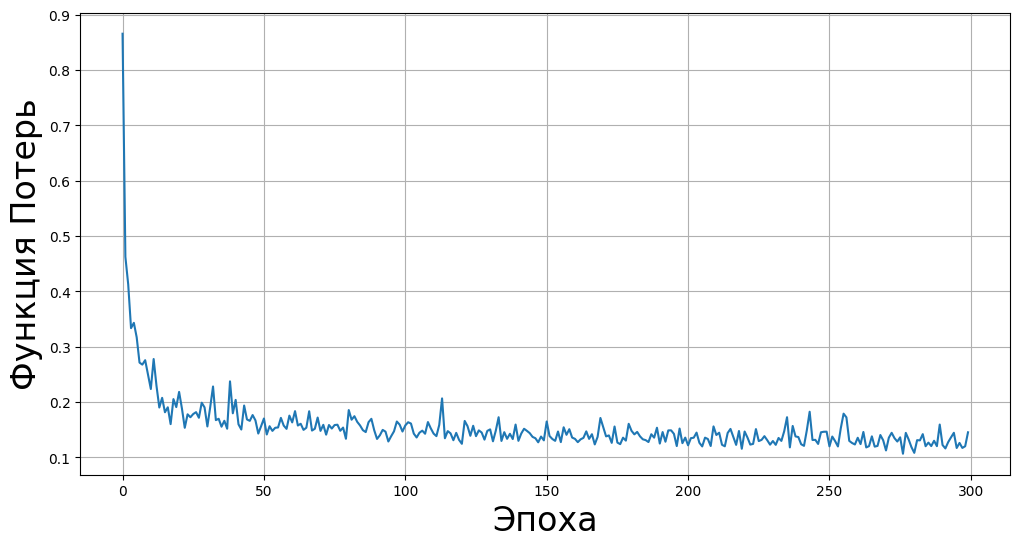

In [575]:
regr_l2 = RidgeRegression(learning_rate=0.25,
                          epochs=300, batch_size=10,
                          l2_penalty = 0.001)
regr_l2.fit(x_train_, y_train)

print(f'Test Score = {regr_l2.score(x_test_, y_test):.2f}, Train Score = {regr_l2.score(x_train_, y_train):.2f}')
regr_l2.plot_cost()

[ 0.89162157 -3.01225341 -2.11566636 -0.52077772 -0.07438506  0.50818461
  1.33448796  1.1050066   0.5965036   0.71107764] 0.5570382767026517


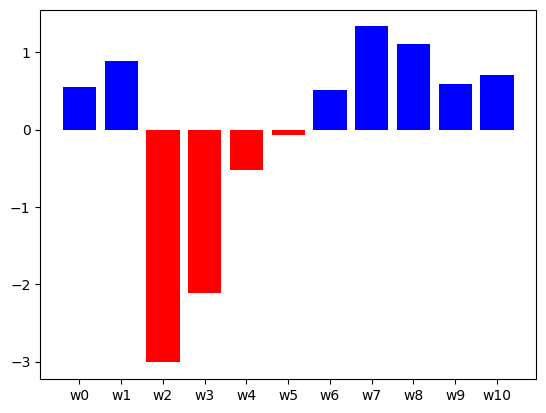

In [576]:
w, b = regr_l2.get_w_and_b()
print(w,b)
vis_weigths(np.hstack([b, w]))

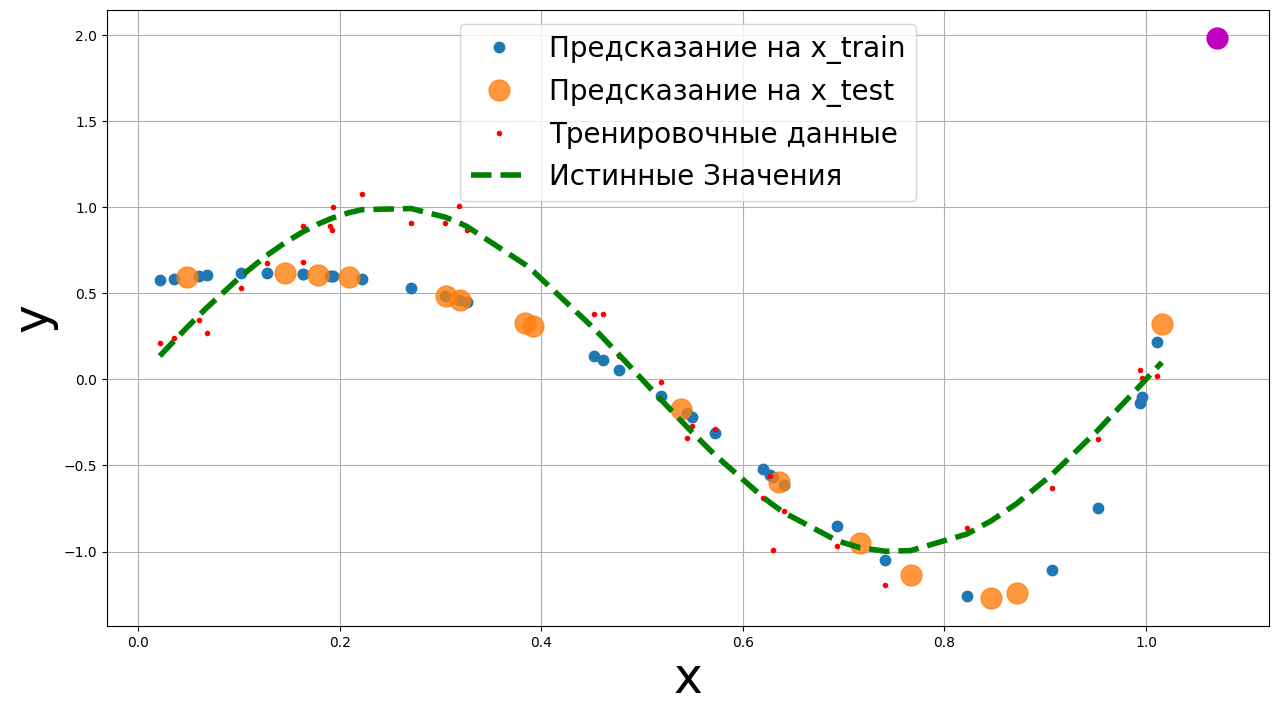

In [577]:
np.sum(np.abs(w))

plt.figure(figsize=(15,8))

plot_model_class(x_train_, y_train, x_test_, x, y_true, regr_l2)

plt.plot([1.07], 
         regr_l2.predict(to_polynom([1.07], order=order)) ,
         'mo',  label = 'new predict',
          markersize = 15)

Регуляризация L1

In [578]:
class LassoRegression(LinearRegression):
    def __init__(self, 
                 learning_rate = 0.5,
                 l1_penalty = 0.001,
                 epochs = 100, 
                 weights = None, 
                 bias    = None, 
                 batch_size   = 1000,
                 n_batches    = None,
                 random_state = 42):
        
        super().__init__(learning_rate = learning_rate,
                         epochs = epochs, 
                         weights = weights, 
                         bias    = bias, 
                         batch_size   = batch_size, 
                         n_batches    = n_batches,
                         random_state = random_state)
        self.l1_penalty = l1_penalty
    
    #---------------------------------
    def loss(self,yhat, y):   
        l1_term = self.l1_penalty*np.sum(np.abs(self.weights[1:]))
        return np.square(yhat - y).mean() + l1_term
                  
    #---------------------------------
    def update(self):    
        return self.weights - self.lr*(self.grad + np.sign(self.weights)*self.l1_penalty)

Test Score = 0.82, Train Score = 0.78


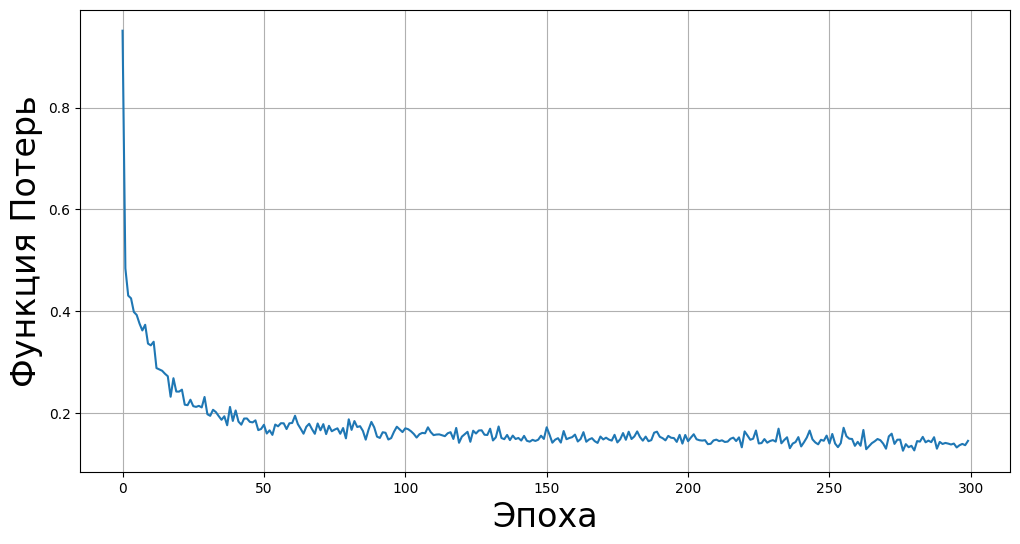

In [579]:
regr_l1 = LassoRegression(learning_rate=0.1,
                          epochs=300, batch_size=10,
                          l1_penalty = 0.001)
regr_l1.fit(x_train_, y_train)

print(f'Test Score = {regr_l1.score(x_test_, y_test):.2f}, Train Score = {regr_l1.score(x_train_, y_train):.2f}')
regr_l1.plot_cost()

[-0.21192094 -2.05030852 -1.33128386 -0.29656473 -0.14598423  0.10726975
  0.93242127  0.8448616   0.55481071  0.89323792] 0.7398342876026794


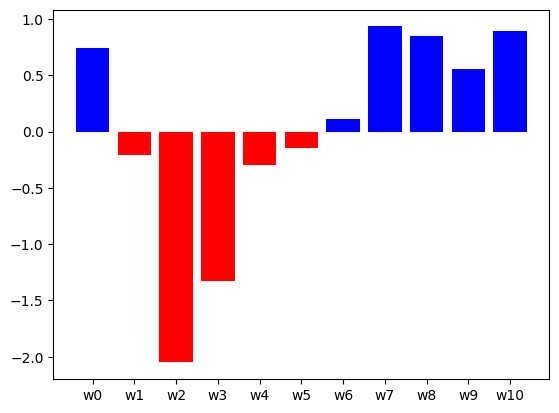

In [580]:
w, b = regr_l1.get_w_and_b()
print(w, b)
vis_weigths(np.hstack([b, w]))

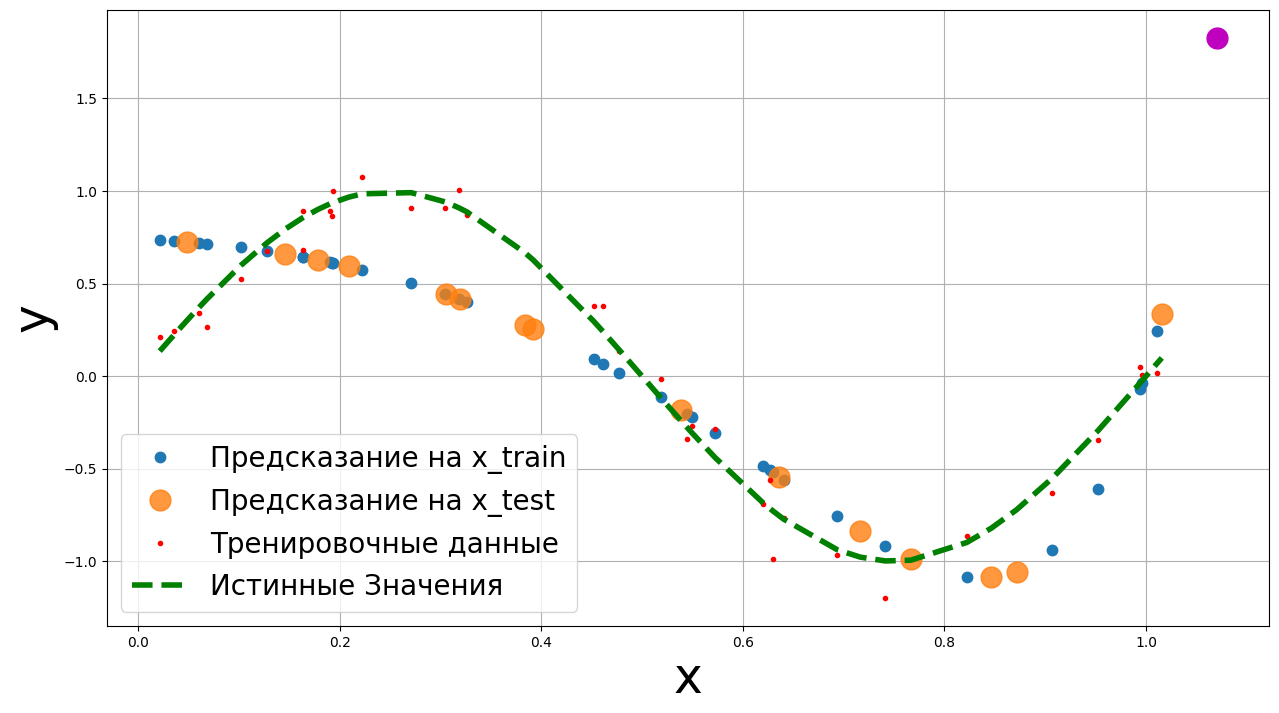

In [581]:
np.sum(np.abs(w))

plt.figure(figsize=(15,8))

plot_model_class(x_train_, y_train, x_test_, x, y_true, regr_l1)

plt.plot([1.07], 
         regr_l1.predict(to_polynom([1.07], order=order)),
         'mo',  label = 'new predict',
          markersize = 15)

Эластичная регуляризация

In [582]:
class ElasticRegression(LinearRegression):
    def __init__(self, 
                 learning_rate = 0.5,
                 l1_penalty = 0.0,
                 l2_penalty = 0.0,
                 epochs = 100, 
                 weights = None, 
                 bias    = None, 
                 batch_size   = 1000, 
                 n_batches    = None,
                 random_state = 42):
        
        super().__init__(learning_rate = learning_rate,
                         epochs = epochs, 
                         weights = weights, 
                         bias    = bias, 
                         batch_size   = batch_size, 
                         n_batches    = n_batches,
                         random_state = random_state)
        self.l1_penalty = l1_penalty
        self.l2_penalty = l2_penalty
        
    #---------------------------------
    def loss(self,yhat, y):   
        l1_term = self.l1_penalty*np.sum(np.abs(self.weights[1:]))
        l2_term = (self.l2_penalty/2)*np.sum(np.square(self.weights[1:]))
        return np.square(yhat - y).mean() + l1_term + l2_term
                  
    #---------------------------------
    def update(self):    
        l2_term = self.l2_penalty*np.sum(self.weights[1:])
        return self.weights - self.lr*(self.grad +  np.sign(self.weights)*self.l1_penalty + l2_term)

Test Score = 0.82, Train Score = 0.78


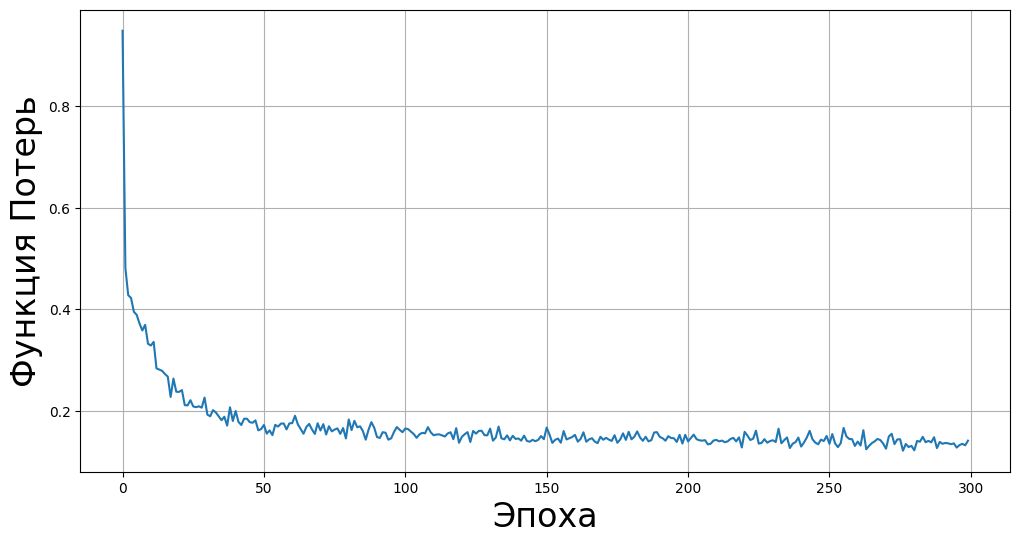

In [583]:
regr_l1l2 = ElasticRegression(learning_rate=0.1,
                         epochs=300,batch_size=10,
                         l1_penalty = 0.0001,l2_penalty = 0.001 )
regr_l1l2.fit(x_train_, y_train)

print(f'Test Score = {regr_l1l2.score(x_test_, y_test):.2f}, Train Score = {regr_l1l2.score(x_train_, y_train):.2f}')
regr_l1l2.plot_cost()

[-0.1864695  -2.04802545 -1.37438678 -0.3391806  -0.26151022  0.1504522
  0.98990432  0.88750445  0.57304665  0.91419269] 0.7394859613430462


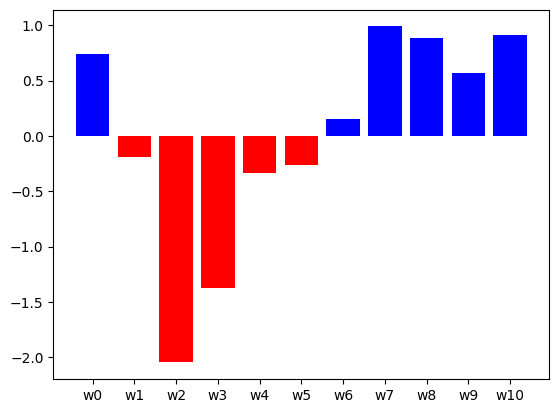

In [584]:
w, b = regr_l1l2.get_w_and_b()
print(w,b)
vis_weigths(np.hstack([b,w]))

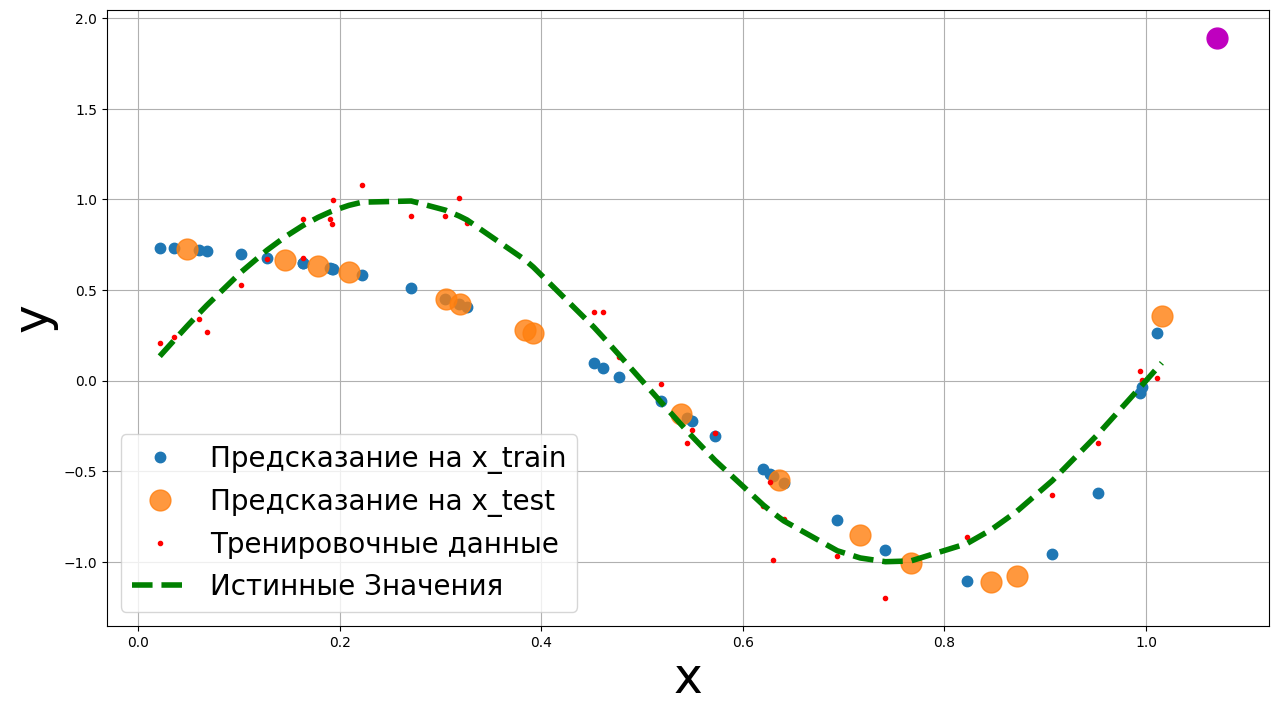

In [585]:
np.sum(np.abs(w))

plt.figure(figsize=(15,8))

plot_model_class(x_train_, y_train, x_test_, x, y_true, regr_l1l2)

plt.plot([1.07], 
         regr_l1l2.predict(to_polynom([1.07], order=order)) ,
         'mo',  label = 'new predict',
          markersize = 15)